## A- LE CHALLENGE

Dans ce challenge, il est demandé d'estimer automatiquement le prix d'un bien immobilier en 2020 en se basant sur les données historiques de 2015 à 2019.

**RETROUVER TOUS LES DETAILS SUR GOOGLE COLAB**: [**ICI**](https://drive.google.com/drive/folders/1Hfv7cHBDSJV7jYfibG90x1mYXjCtEM5B?usp=sharing)



## B0- CONNECTION ET IMPORT DES LIBRAIRIES

In [1]:
from google.colab import drive
import os
drive.mount("/content/gdrive")
os.chdir("/content/gdrive/My Drive/EDSC2")
os.listdir()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


['data', 'models', 'Tutoriel.ipynb', 'sample_submission.csv']

In [2]:
import pandas as pd

import torch
import tensorflow as tf
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_percentage_error
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

import os
import shutil
import random


In [3]:
def seed_everything(seed=2020):
    #fonction utilitaire pour avoir garantir des résultats reproductibles
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
#=================================

In [4]:
seed_everything(777)

## B1- DECOUVRONS LES DONNEES

Le jeu d'entraînement contient 15 variables. Cependant le jeu de test contient que 14 variables (la variable à prédire étant absente). On donne une brève description des variables:

* **id**: l'identifiant unique du bien immobilier
* **date_evaluation**: La date à laquelle on souhaite évaluer le prix du bien
*  **year**: l'année de la date d'évaluation
* **estimation_prix**: l'estimation du prix du bien (variable à prédire)
* **adresse_code_voix**: l'adresse code voie du bien anonymisé
* **code_postal**: le code postal anonymisé
* **nom_commune**: le nom de la commune anonymisé
*  **code_commume**: le code commune anonymisé
*  **departement**: le code commune anonymisé
*  **type_local**: le type de local qui contient deux modalités (Maison ou Appartement)
*  **surface_reelle_bati**: C'est la superficie éffective sur laquelle on a déjà construit (il arrive que les proporiétaires ne construisent pas sur la totalité de leur terrain.)
* **surface_terrain** : C'est la superficie totale du terrain
* **nombres_pieces_principales**: le nombre de la pièces du bien
* **longitude**: la longitude anonymisée (elle est normalisée sur une échelle de 0 à 100 par des valeurs que nous ne pouvons pas réveler)
* **latitude**: la latitude anonymisée (elle est normalisée sur une échelle de 0 à 100 par des valeurs que nous ne pouvons pas réveler)

In [5]:
df = pd.read_csv('./data/train.csv')
te = pd.read_csv('./data/test.csv')

In [6]:
print('SHAPE TRAIN:', df.shape)
print('SHAPE TEST:', te.shape)
print("="*30)
print("TRAIN YEARS:", df.year.unique())
print("TEST YEAR:", te.year.unique())

SHAPE TRAIN: (2243649, 15)
SHAPE TEST: (137349, 14)
TRAIN YEARS: [2014 2017 2018 2015 2016 2019]
TEST YEAR: [2020]


In [7]:
df.head(3)

,date_evaluation,estimation_prix,adresse_code_voie,code_postal,nom_commune,code_commune,type_local,surface_reelle_bati,surface_terrain,nombre_pieces_principales,longitude,latitude,departement,year,id
0,2014-01-09,251500.0,8671,1699,5181,5527,Maison,147.0,1501.0,5.0,69.771710,50.195540,16,2014,0
1,2017-06-12,325000.0,5080,1699,5181,5527,Maison,132.0,896.0,4.0,69.784632,50.178470,16,2017,1
2,2018-04-13,236850.0,8671,1699,5181,5527,Maison,108.0,1358.0,4.0,69.761486,50.184971,16,2018,2


In [8]:
# On codifie la variable type_local
df['type_local'] = df['type_local'].map({'Maison':1, 'Appartement':0})
te['type_local'] = te['type_local'].map({'Maison':1, 'Appartement':0})

## B2- PREMIER MODELE

* On va se servir d'un Xgboost comme benchmark en utilisant que les variables initiales comme benchmark.
* Pour se challenge la métrique sera le MAPE (mean averape percentage error) en raison de l'échelle des prix immobiliers qui sont généralement en centaine de milles.
* Ensuite on donnera des hints sur comment améliorer les performances.

In [9]:
if 'models' not in os.listdir(): os.mkdir('models')
if 'xgboost' not in os.listdir('models'): os.mkdir('models/xgboost')

In [10]:
def fit_xgb(Xs, Xe, ys, folds, params, rounds):
    """
    cette fonction entraine un xgboost à partir des features, label, folds, paramètres et le nombre
    d'itérations.
    """
    preds = np.zeros(ys.shape)
    NFOLDS = len(folds)
    pe = 0.
    
    for idx in range(NFOLDS):
        print("FOLD:", idx+1)
        tr_idx, val_idx = folds[idx]
  
        dtrain = xgb.DMatrix(Xs[tr_idx], ys[tr_idx])
        dvalid = xgb.DMatrix(Xs[val_idx], ys[val_idx])
        dtest = xgb.DMatrix(Xe)
        reg = xgb.train(params,
                      dtrain=dtrain,
                      num_boost_round=rounds,
                      evals=[(dtrain, "train"), (dvalid, "valid")],
                      verbose_eval=250,
                      early_stopping_rounds=500, 
                      #feval='rmse'
                      )
        #
        reg.save_model(f"./models/xgboost/xgb_model_{idx}")
        preds[val_idx] = reg.predict(dvalid)
        pe += reg.predict(dtest) / NFOLDS
    #
    return preds, pe
#=========================================

In [11]:
GPU = torch.cuda.is_available() #teste la disponibilié d'un GPU
PARAMS = {
        "subsample": 0.60,
        "colsample_bytree": 0.40,
        "max_depth": 5,#6>10
        "learning_rate": 0.02,
        "objective":"reg:squarederror",
        'disable_default_eval_metric': 1,
        'eval_metric':'rmse',
        "nthread": -1,
        #"tree_method": "gpu_hist",
        #"gpu_id": 0,
        #"max_bin": 128, 
        'min_child_weight': 2,
        'reg_lambda': 0.001,
        'reg_alpha': 0.01, 
        'seed' : 2021,
    }
if GPU:
    PARAMS['tree_method']  = 'gpu_hist'
    PARAMS['gpu_id'] = 0
#================
ROUNDS = 1000
print(GPU)

True


In [12]:
TGT = 'estimation_prix'
FE = ['adresse_code_voie','code_postal', 'nom_commune', 'code_commune', 'type_local','surface_reelle_bati', 'surface_terrain', 
      'nombre_pieces_principales','longitude', 'latitude', 'departement', 'year']
#

In [13]:
X = df[FE].values #les variales entraînement
Xe = te[FE].values #les variales test
y = df[TGT].values #la cile
z=  df['code_postal'].values #variable de stratification
NFOLDS = 5 #nombre de folds

skf = StratifiedKFold(NFOLDS, shuffle=True)
FOLDS = list(skf.split(X, z))

In [14]:
preds, pe = fit_xgb(X, Xe, y, FOLDS, PARAMS, ROUNDS)

FOLD: 1
[0]	train-rmse:200548	valid-rmse:200466
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[250]	train-rmse:60893.1	valid-rmse:61018.3
[500]	train-rmse:58890.8	valid-rmse:59009.3
[750]	train-rmse:57865.3	valid-rmse:57997.3
[999]	train-rmse:57234.7	valid-rmse:57382.4
FOLD: 2
[0]	train-rmse:200508	valid-rmse:200634
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[250]	train-rmse:60882.1	valid-rmse:61022.2
[500]	train-rmse:58863	valid-rmse:59031.4
[750]	train-rmse:57868.9	valid-rmse:58063.4
[999]	train-rmse:57235.1	valid-rmse:57452.5
FOLD: 3
[0]	train-rmse:200471	valid-rmse:200775
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[250]	train-rmse:60871	valid-rmse:60868.4
[500]	train-rmse:58857	val

In [15]:
preds.shape

(2243649,)

In [16]:
print('SCORE VALIDATION:',  np.round( 100.*mean_absolute_percentage_error(y, preds), 3 ), '%'  )

SCORE VALIDATION: 28.729 %


## B3a- PISTES D'AMELIORATION

* **a) traitement des données**: la gestion des outliers, désaisonnalisation (?), transformation de type Box-Cox sur la variable cible, etc.
* **b) Features Engineering**: Mean Encoding, Estimation du prix historique au m2, Features géospatiales (maximiser l'usage de la longitude/latitude), etc
    * Attention en faisant le mean encoding ou l'estimation du prix au m2, il faut plutôt encoder avec les valeurs passées car c'est un problème de séries temporelles. En effet en prédisant pour l'année 2020 vous ne disposez pas des données de 2020, vous ne pourrez qu'encoder qu'avec les valeurs passées. Ceci vous aidera à limiter le sur-apprentissage.
* **c) Autres modèles** : d'autres modèles comme LightGBM, Random Forest, Knn, Les réseaux de neurones, les approches séries temporelles. **N'OUBLIEZ PAS DE BAGGER LES PREDICTIONS DE PLUSIEURS MODELES DIFFERENTS**
* **d)Optimisation des hyperparamètres** : A faire pour chaque modèles
* **e)Autres techniques (from my Kaggle experience)**: Modèle stacking, le Pseudo-Labelling, post-processing astucieux, etc.

## B3b- EXAMPLE D'AMELIORATION : MEAN-ENCODING & PRIX HISTORIQUE DU M2

In [17]:
def get_past_avg(_df, _dg, col):
    """
    `_df` represente le jeu de données.
    Cette fonction permet de calculer une estimation moyenne de l'année precedente
    suivant les modalites de la variable catégorielle `col`.
    la colonne générée est {col}_avg
    """
    dg_temp = _dg.groupby(['year','type_local',col])['estimation_prix'].mean().reset_index()
    dg_temp['year'] += 1
    dg_temp.columns = ['year','type_local',col,f'{col}_avg']
    _df = _df.merge(dg_temp, on=['year','type_local',col], how='left')
    return _df
#====================================
def avg_pst_price(_df, _dg, col):
    """
    On calcule le prix historique au m2 en controllant par le type local et la variable catégorielle `col`
    le prix s'appelle prix_{col}
    On déduit une estimation prop_{col}
    """
    sfcol = 'surface_reelle_bati'
    keys = [col] + ['type_local','year']
    
    sl = _dg.groupby(keys)[[sfcol,'estimation_prix']].mean().reset_index()
    new_col = f'prix_{col}'
    sl[new_col] = sl['estimation_prix'] / sl[sfcol]
    ##sl_ = sl[keys + [new_col]].copy() #pour backfilling
    sl['year'] += 1
    ##sl = sl.merge(sl_, on=keys, how='outer', suffixes=['','_']) #années actuelles et passées
    
    sl.drop([sfcol,'estimation_prix'], axis=1, inplace=True)
    ##sl.loc[sl[new_col].isnull(), new_col] = sl.loc[sl[new_col].isnull(), f'{new_col}_']
    ##sl.drop(f'{new_col}_', axis=1, inplace=True)
    
    _df = _df.merge(sl, on=keys, how='left')
    _df[f'prop_{col}'] = _df[new_col] * _df[sfcol]
    return _df
#

In [18]:
for catcol in ['code_postal','nom_commune']:
  df = get_past_avg(df, df, catcol)
  te = get_past_avg(te, df, catcol)
  te = avg_pst_price(te, df, catcol)
  df = avg_pst_price(df, df, catcol)
#===

In [19]:
df.head()

,date_evaluation,estimation_prix,adresse_code_voie,code_postal,nom_commune,code_commune,type_local,surface_reelle_bati,surface_terrain,nombre_pieces_principales,...,latitude,departement,year,id,code_postal_avg,prix_code_postal,prop_code_postal,nom_commune_avg,prix_nom_commune,prop_nom_commune
0,2014-01-09,251500.0,8671,1699,5181,5527,1,147.0,1501.0,5.0,...,50.195540,16,2014,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-06-12,325000.0,5080,1699,5181,5527,1,132.0,896.0,4.0,...,50.178470,16,2017,1,192148.604651,1715.968847,226507.887850,234892.857143,1851.632883,244415.540541
2,2018-04-13,236850.0,8671,1699,5181,5527,1,108.0,1358.0,4.0,...,50.184971,16,2018,2,188370.731707,1632.811839,176343.678647,171450.000000,1492.167102,161154.046997
3,2018-04-23,186000.0,8247,1699,5181,5527,1,123.0,785.0,5.0,...,50.191543,16,2018,3,188370.731707,1632.811839,200835.856237,171450.000000,1492.167102,183536.553525
4,2014-01-11,370000.0,8265,2084,5752,6124,1,220.0,880.0,8.0,...,49.106485,16,2014,4,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
print('missing train:', df.prix_code_postal.isnull().mean())
print('missing test:', te.prix_code_postal.isnull().mean())

missing train: 0.15245744766672506
missing test: 0.022067870898222777


In [21]:
FE2 = FE + ['code_postal_avg','prix_code_postal','prop_code_postal','prix_nom_commune','prop_nom_commune']

In [22]:
X = df[FE2].values #les variales entraînement
Xe = te[FE2].values #les variales test

In [23]:
preds, pe = fit_xgb(X, Xe, y, FOLDS, PARAMS, ROUNDS)

FOLD: 1
[0]	train-rmse:200507	valid-rmse:200422
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[250]	train-rmse:57272.9	valid-rmse:57418
[500]	train-rmse:56018.5	valid-rmse:56188.9
[750]	train-rmse:55478	valid-rmse:55675.2
[999]	train-rmse:55149.1	valid-rmse:55375.3
FOLD: 2
[0]	train-rmse:200464	valid-rmse:200589
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[250]	train-rmse:57288.1	valid-rmse:57404.7
[500]	train-rmse:56013.3	valid-rmse:56175.7
[750]	train-rmse:55461	valid-rmse:55664.7
[999]	train-rmse:55123.9	valid-rmse:55365.7
FOLD: 3
[0]	train-rmse:200426	valid-rmse:200732
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[250]	train-rmse:57269	valid-rmse:57342.6
[500]	train-rmse:56023.5	valid

In [24]:
print('SCORE VALIDATION:',  np.round( 100.*mean_absolute_percentage_error(y, preds), 3 ), '%'  )
print('On constate une amélioration des performances')

SCORE VALIDATION: 27.674 %
On constate une amélioration des performances


## B4- SUBMISSION

In [25]:
sub = te[['id']].copy()
sub[TGT] = pe

In [26]:
sub.to_csv('sample_submission.csv', index=False)

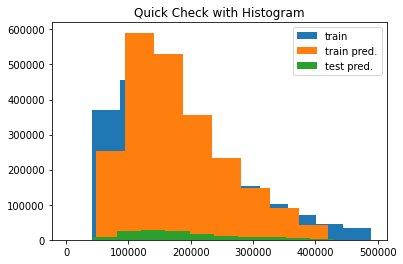

In [27]:
plt.hist(y, label='train')
plt.hist(preds, label='train pred.')
plt.hist(pe, label='test pred.')
plt.legend(loc='best')
plt.title('Quick Check with Histogram')
plt.show()